# To do:

### Light cone data
* ~~Overall magnitude distribution~~
* ~~cut into 2 degree chunks and do mag. distributions~~
* ~~RA + Dec diagram~~
* ~~median mag vs z~~

### ML 
* ~~Run with broadband photometry (on ANNZ_BDT) without errors, photometry to suply is i_auto, umag, bmag, vmag, gmag, rmag, jmag, kmag~~



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = gca().axes.get_xlim(),gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
# data = pd.read_csv("../../Data/PAUS_866.csv")
# data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")

In [4]:
# data.columns.values

In [5]:
lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif os.environ['NAME'] == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

# RA DEC

In [6]:
ra = np.array(LC_DATA_CORE['Data/ra'])
print(ra.size)

7403978


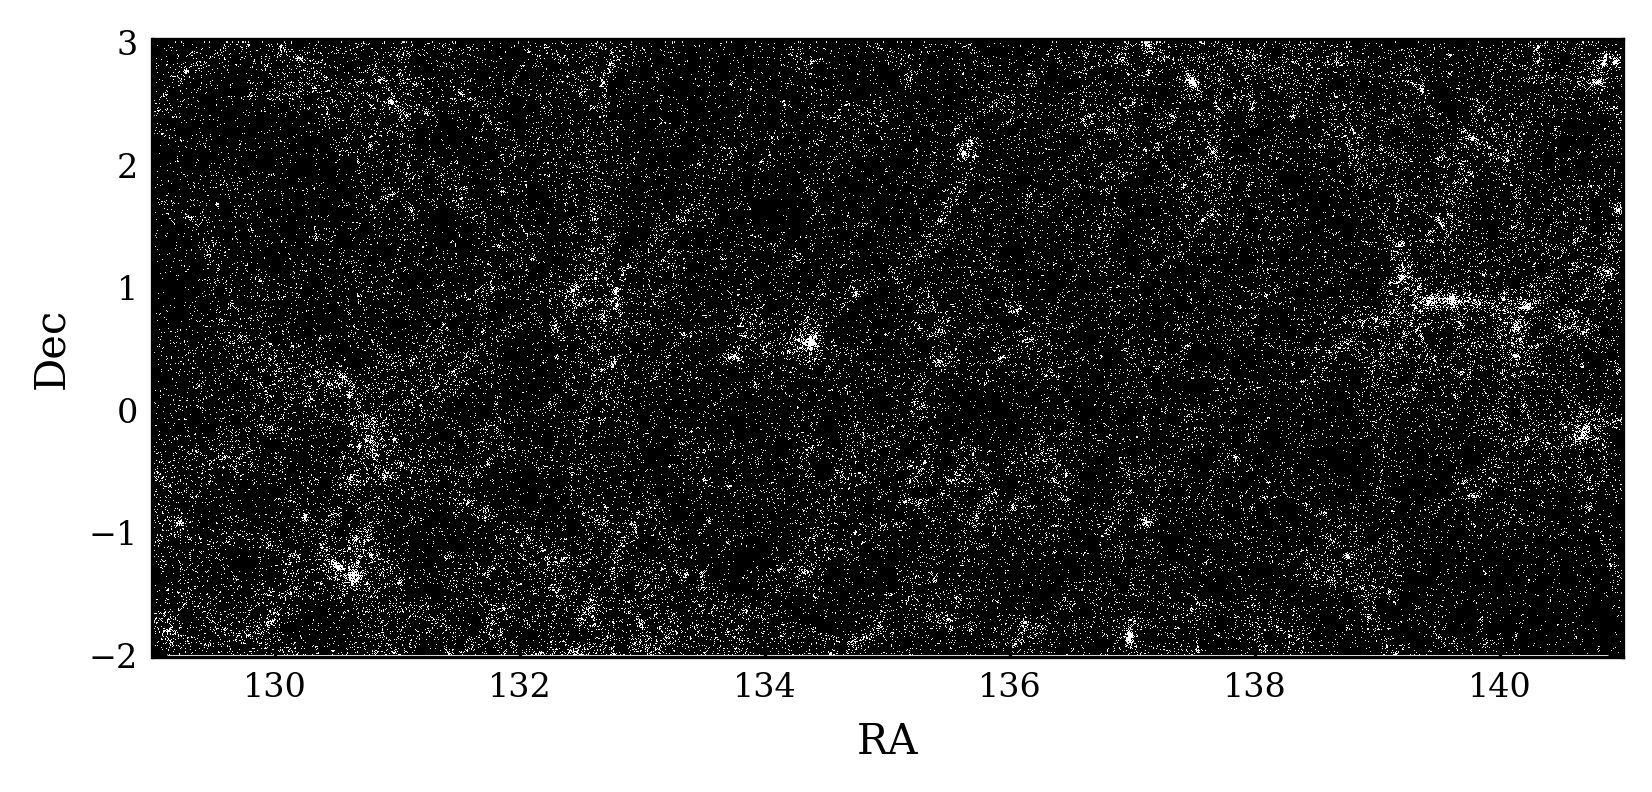

Mock range:11.999984741210938x4.999998211860657


In [8]:
ra = np.array(LC_DATA_CORE['Data/ra'])
dec = np.array(LC_DATA_CORE['Data/dec'])
zs = np.array(LC_DATA_CORE['Data/z_cos'])

indices = (zs >= 0.3-0.02) & (zs <= 0.3+0.02)  #& (ra < np.median(ra)+2.5) & (ra > np.median(ra)-2.5)
ra_samp,dec_samp = ra[indices],dec[indices]


factor = 1/11.6 * 1*latex_textwidth/72
plt.figure(figsize=(11.6*factor,5*factor),dpi=300)
pixs = 1500
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
plt.hist2d(ra_samp,dec_samp,[pixs,pixs],cmap='binary_r',norm=norm)
plt.ylabel('Dec')
plt.xlabel('RA')

plt.axis('equal')
plt.xlim([129,141])
# plt.colorbar()
plt.show()

print('Mock range:{}x{}'.format(ra.max()-ra.min(),dec.max()-dec.min()))

[6.32277778 6.32277778]


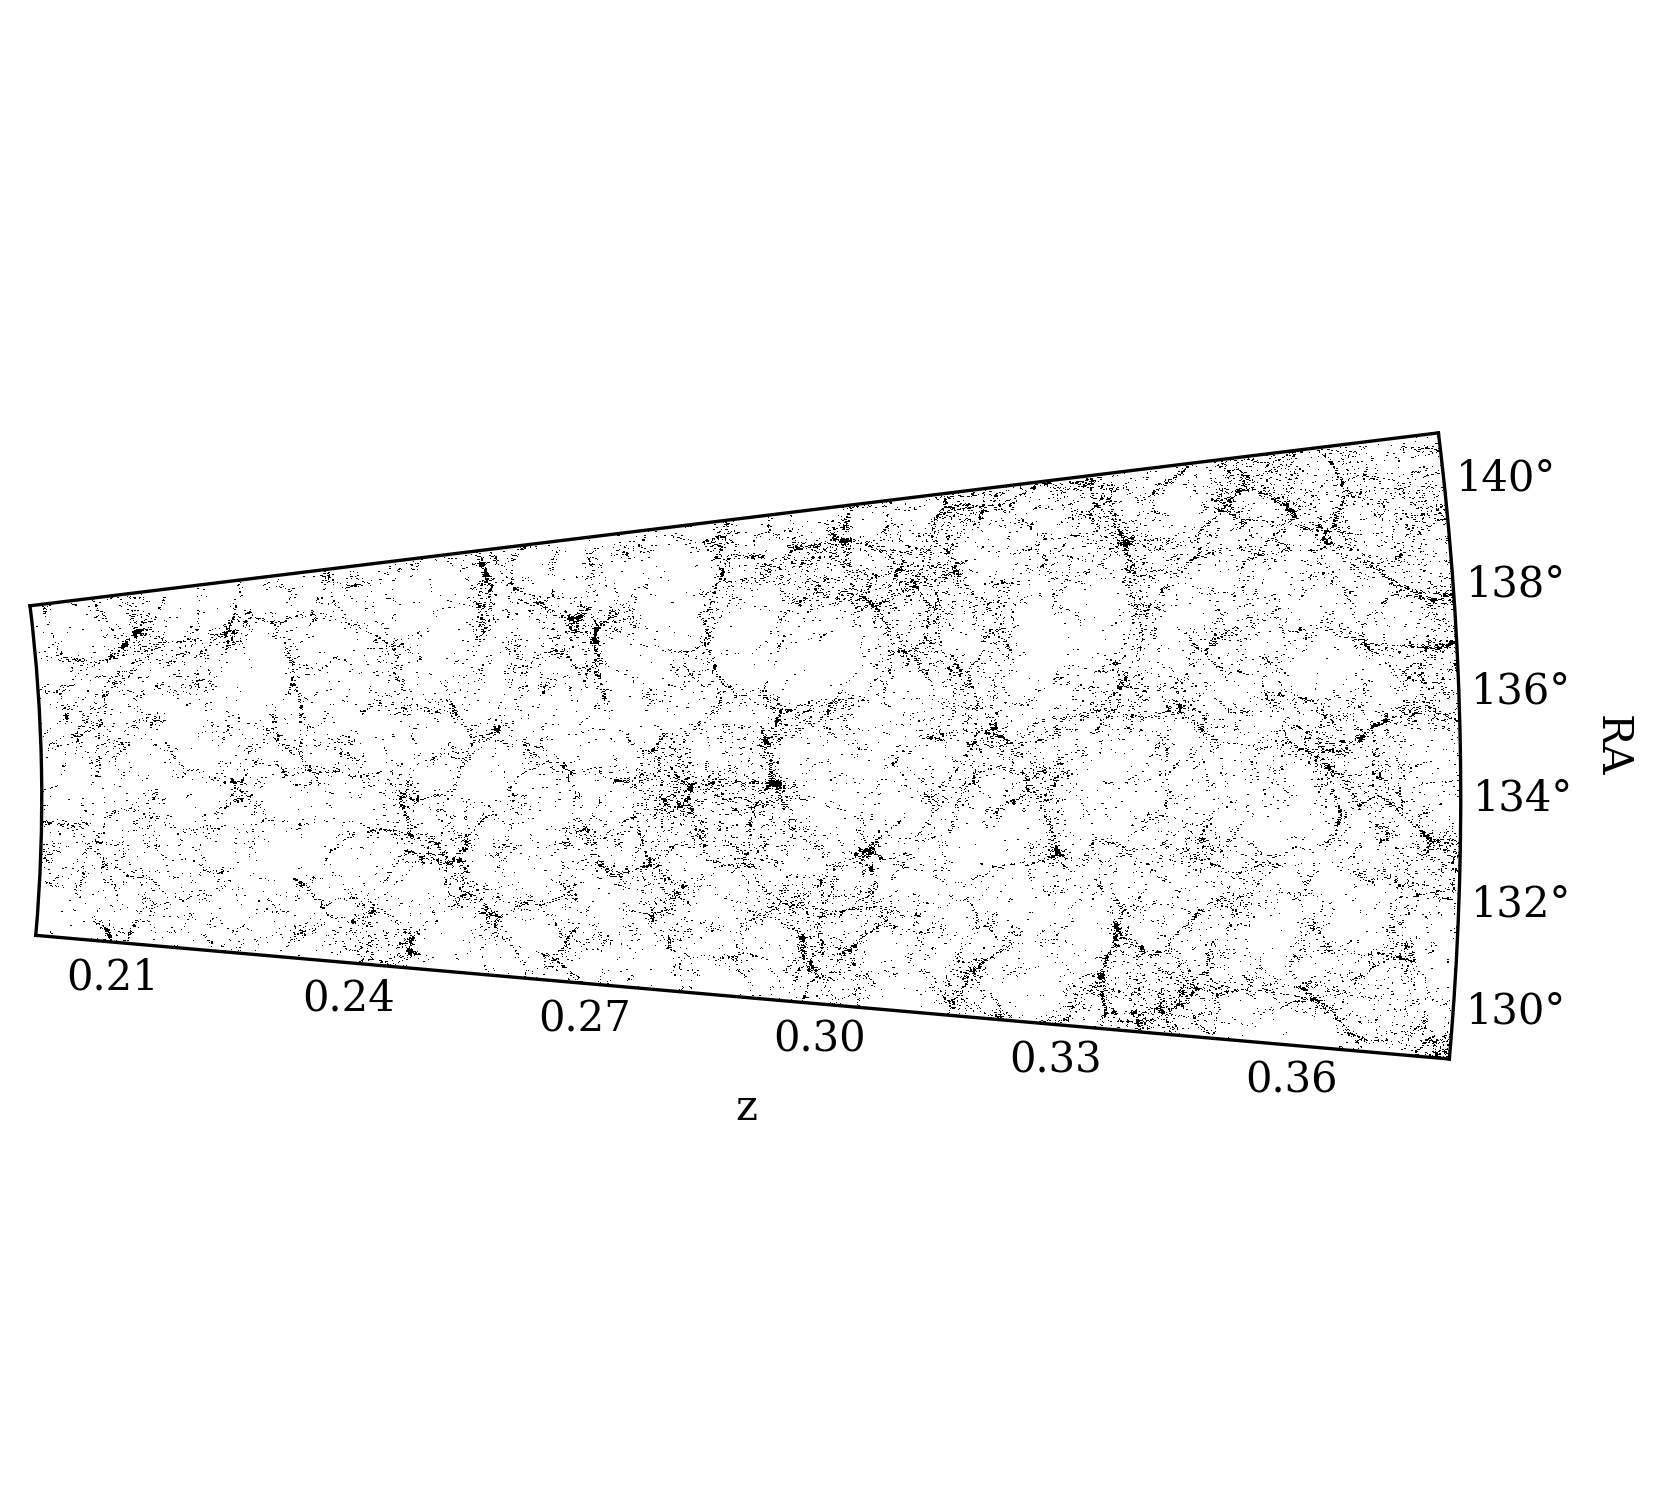

In [20]:
factor = latex_textwidth/72
fig = plt.figure(figsize=(factor,factor),dpi=300)
print(fig.get_size_inches())
ax = plt.subplot(111,projection='polar')

ra = np.array(LC_DATA_CORE['Data/ra'])
dec = np.array(LC_DATA_CORE['Data/dec'])
zs = np.array(LC_DATA_CORE['Data/z_cos'])

dec_med = np.median(dec)
indices = (dec >= dec_med-0.3) & (dec <= dec_med+0.3) & (zs <= 0.38) & (zs >= 0.2) 
zs_samp,ra_samp = zs[indices],ra[indices]*np.pi/180
pixs = 1000
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.hist2d(ra_samp,zs_samp,[pixs,pixs],cmap='binary',norm=norm,zorder=1)
a = np.zeros(500)
a[:] = 0.24
# plt.plot(np.linspace(0,2*np.pi,500),a,'-',color='gray',linewidth=0.5,zorder=3)

# ax.set_thetamax(139) 
# ax.set_thetamin(129)
ax.set_rmin(0.2)
ax.set_rmax(0.38)
ax.set_rorigin(0)
ax.set_theta_offset((-129-5)*np.pi/180)
plt.xlabel('z')
ax.set_ylabel('RA',rotation=-90)
ax.yaxis.set_label_position("right")
ax.yaxis.labelpad = 41
ax.xaxis.labelpad = -90
ax.xaxis.set_tick_params(pad=8)
plt.yticks(rotation=180)

from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(7))
# plt.tight_layout()
plt.show()

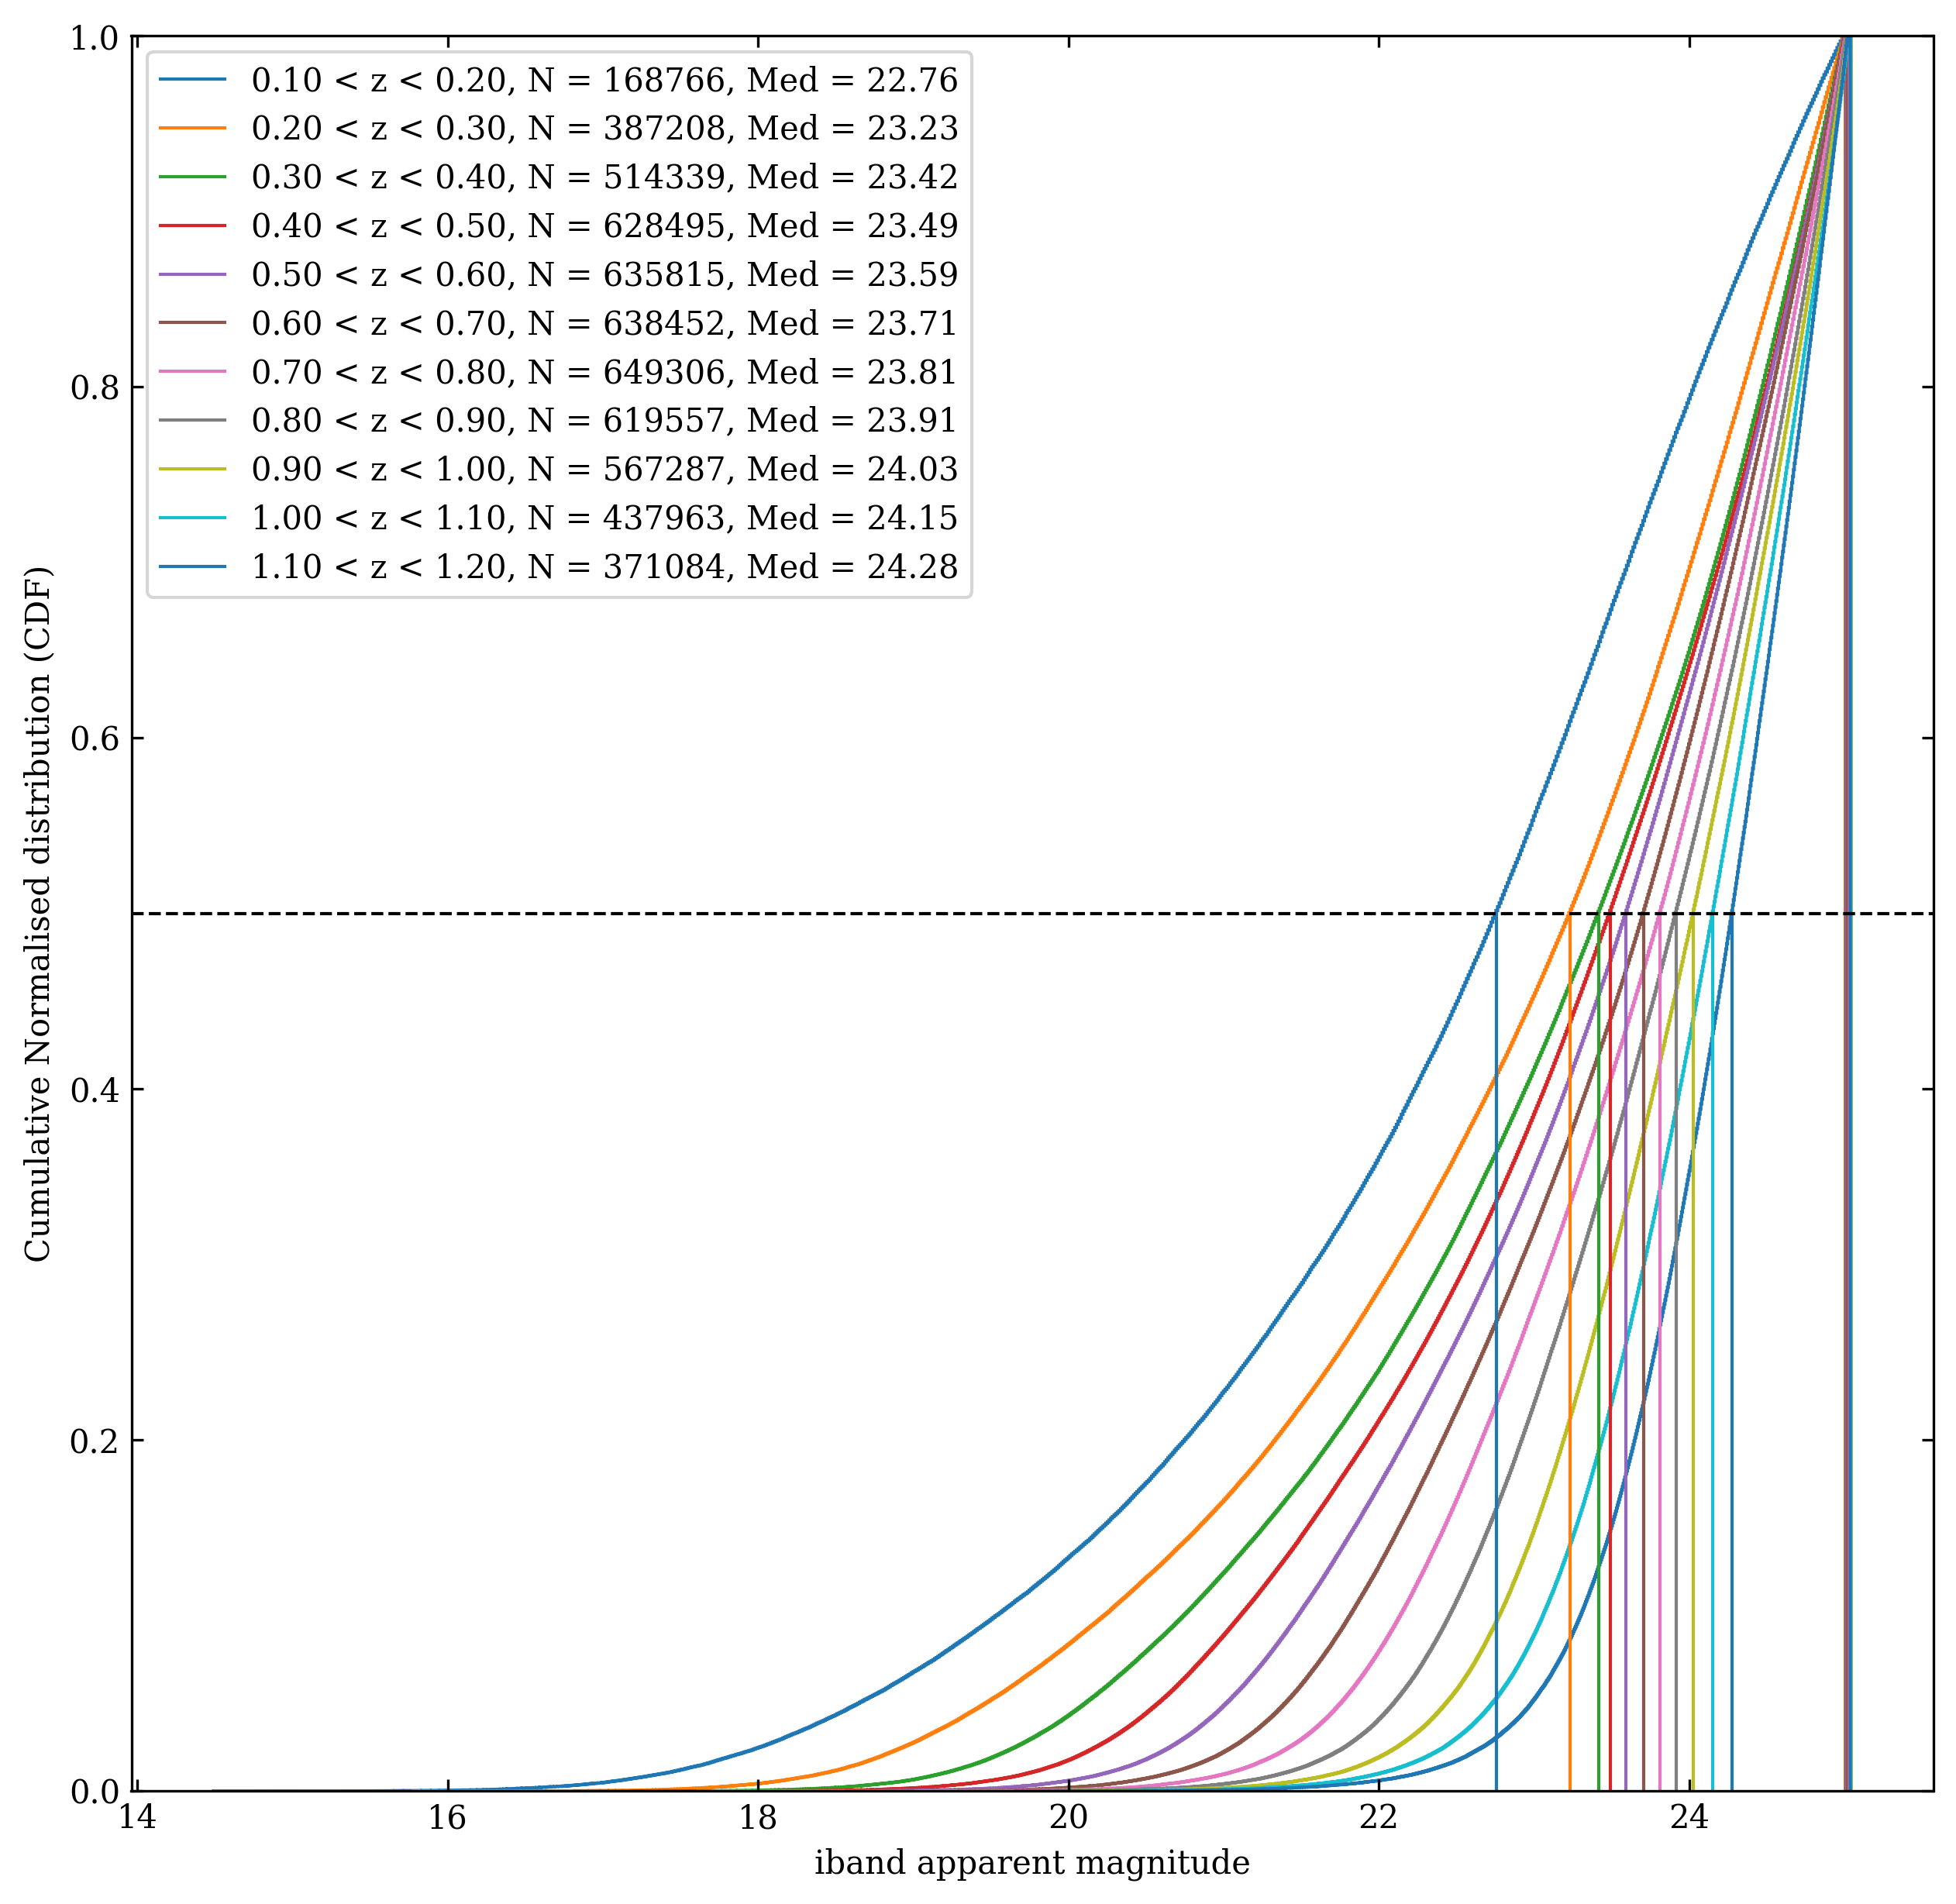

In [9]:
# LC_DATA_PHOTOM.visit(lambda x: print(x))
imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])
# print(zs.min(),zs.max())

plt.figure(figsize=(10,10),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.1
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

for ind,z_bin in enumerate(bins):
    
    truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) 
    
    iband_mags = imags[truth_table]
    N_objects = iband_mags.size
    median = np.median(iband_mags)

    hist = plt.hist(iband_mags,1000,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='{:.02f} < z < {:.02f}, N = {}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],N_objects,median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('iband apparent magnitude')
plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend()
plt.show()

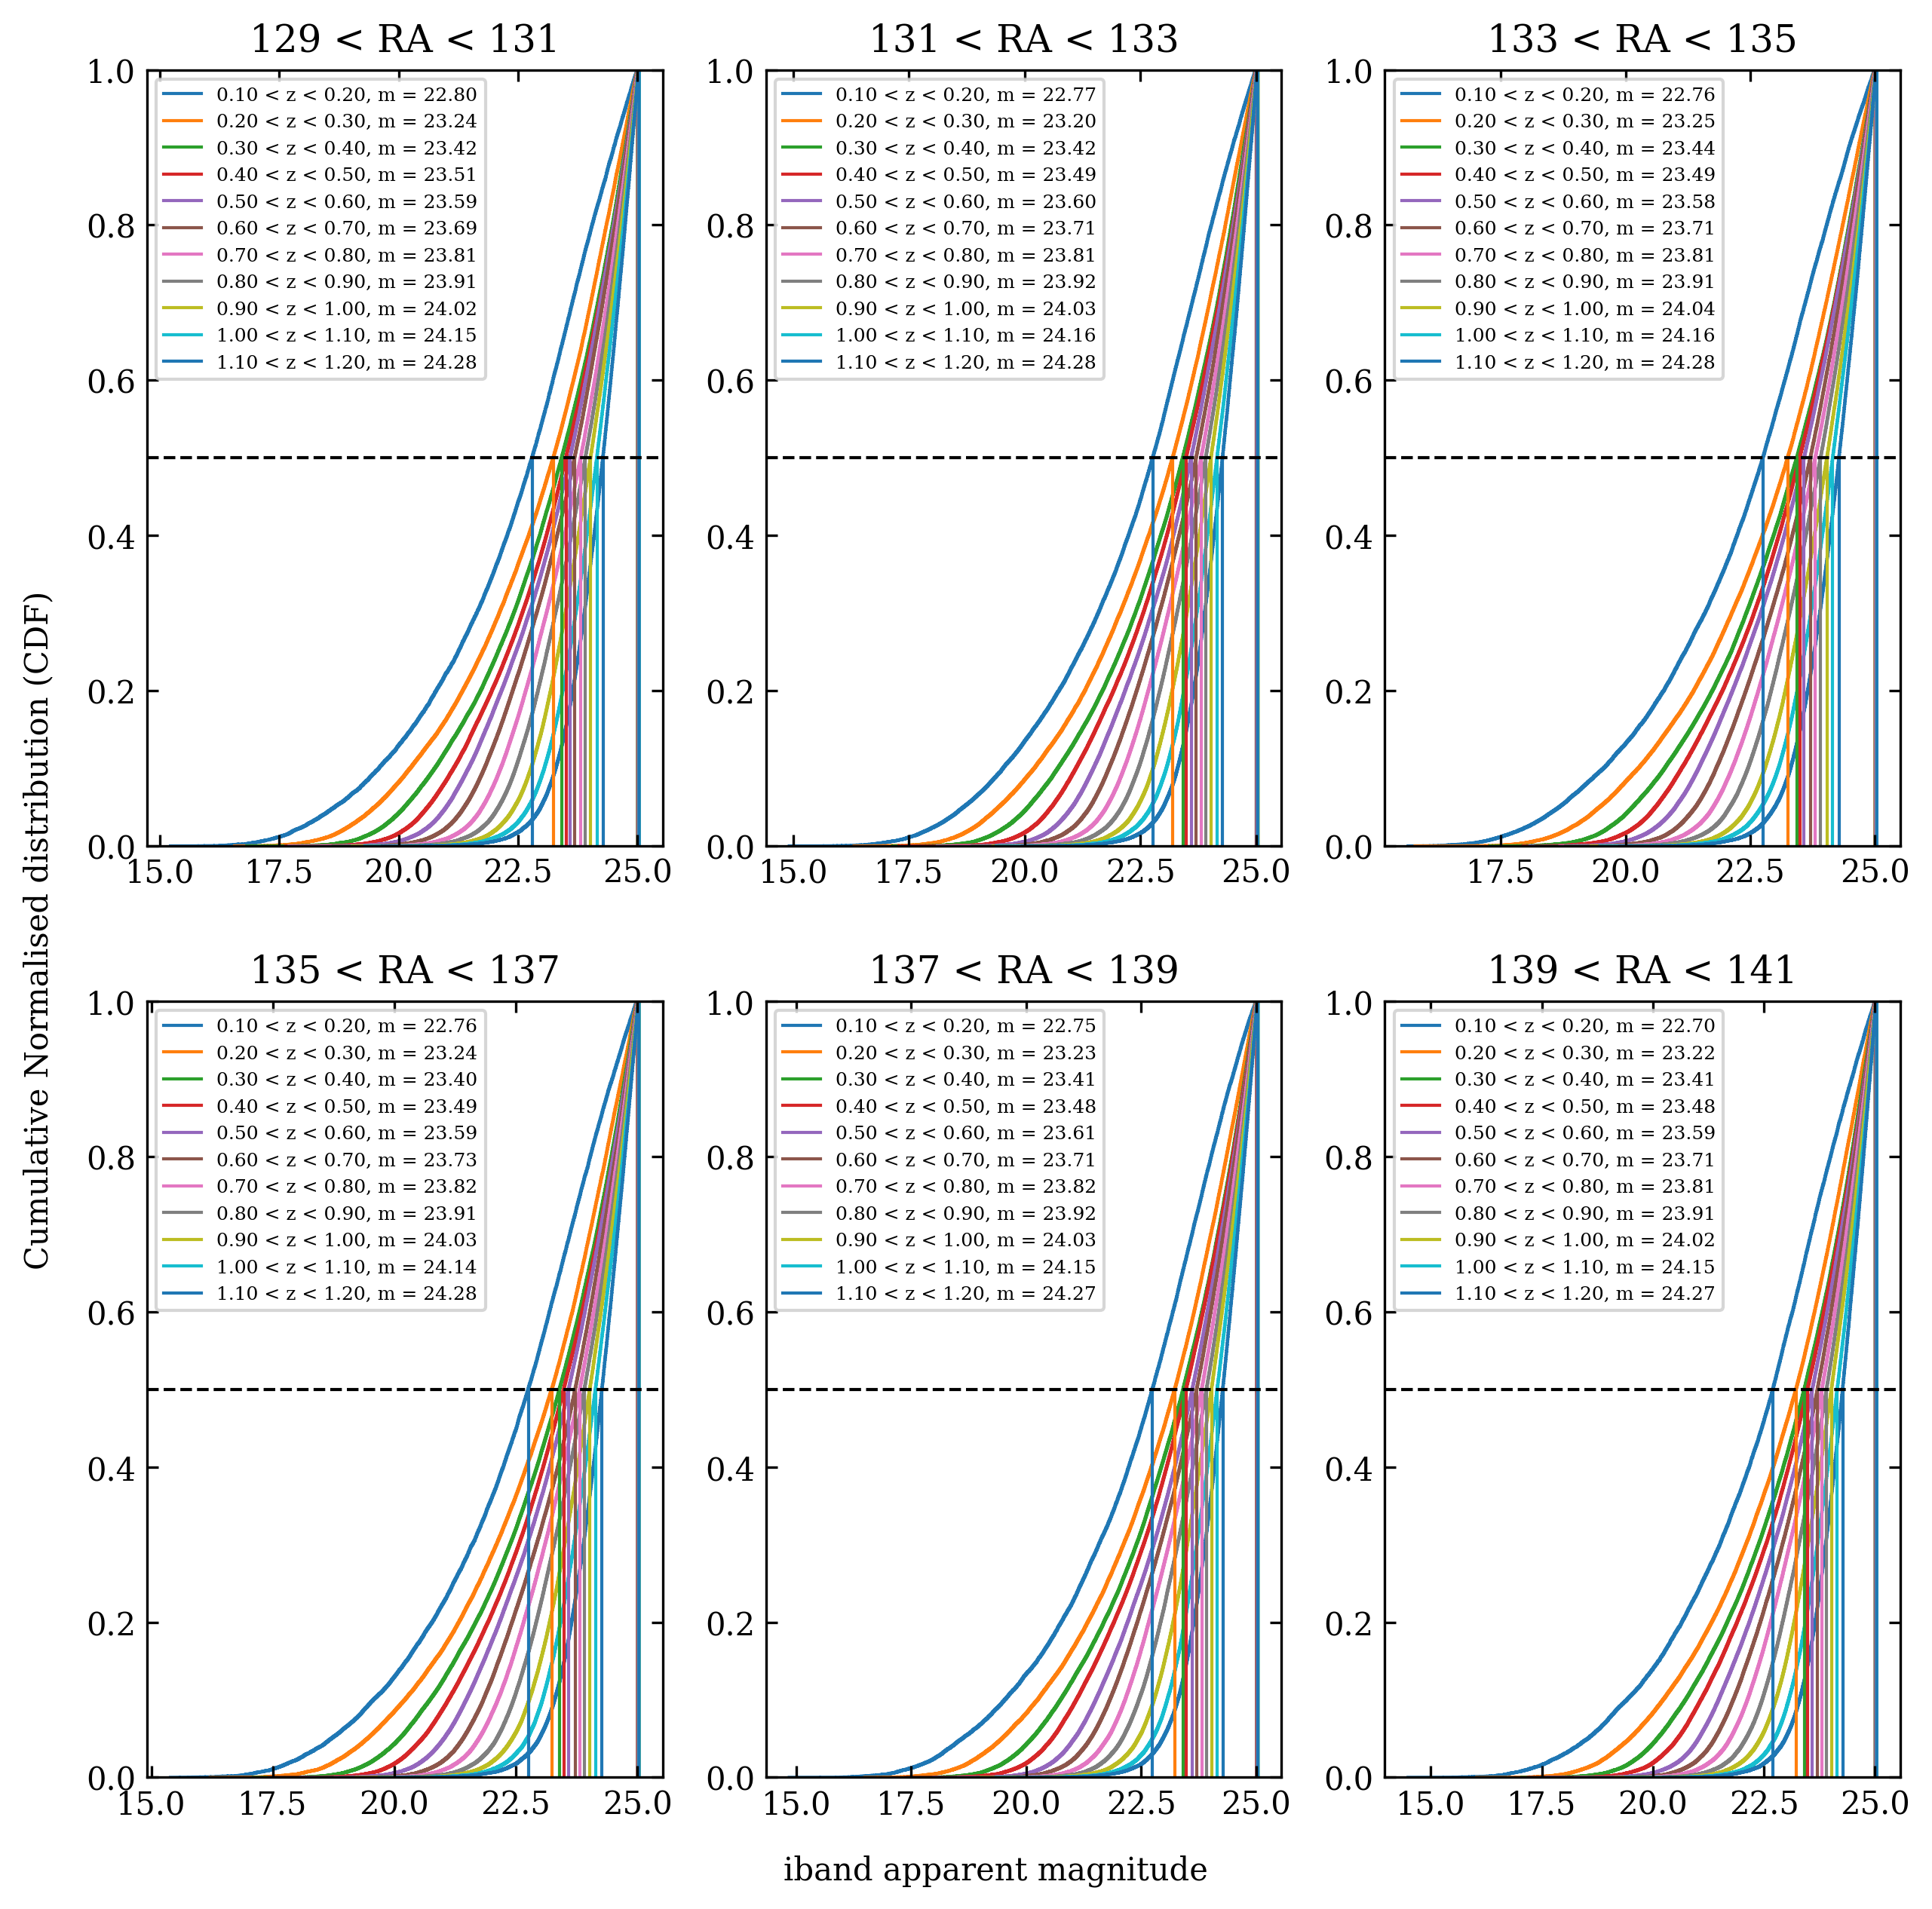

In [10]:
imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])


fig = plt.figure(figsize=(10,10),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.1
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])
# print(bins)

ra_bins = np.arange(129,142,2)
for i in range(ra_bins.size-1):
    plt.subplot(231+i)
    
    for ind,z_bin in enumerate(bins):

        truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) & (ra >= ra_bins[i]) & (ra <= ra_bins[i+1])

        iband_mags = imags[truth_table]
        N_objects = iband_mags.size
        median = np.median(iband_mags)

        hist = plt.hist(iband_mags,1000,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
        plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                    label='{:3.2f} < z < {:3.2f}, m = {:4.2f}'.format(z_bin[0],z_bin[1],median))

    plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
#     plt.xlabel('iband apparent magnitude')
#     plt.ylabel('Cumulative Normalised distribution (CDF)')
    plt.ylim((0,1))
    plt.legend(fontsize=6,loc='upper left')
    plt.title('{:d} < RA < {:d}'.format(ra_bins[i],ra_bins[i+1]))

# plt.subplot(111)
# plt.xlabel('iband apparent magnitude')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
fig.text(0.5, 0.08, 'iband apparent magnitude', ha='center')
fig.text(0.07, 0.5, 'Cumulative Normalised distribution (CDF)', va='center', rotation='vertical')
plt.show()

In [11]:
#CUT
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

z_photos = data_sample['zb']

/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrew/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


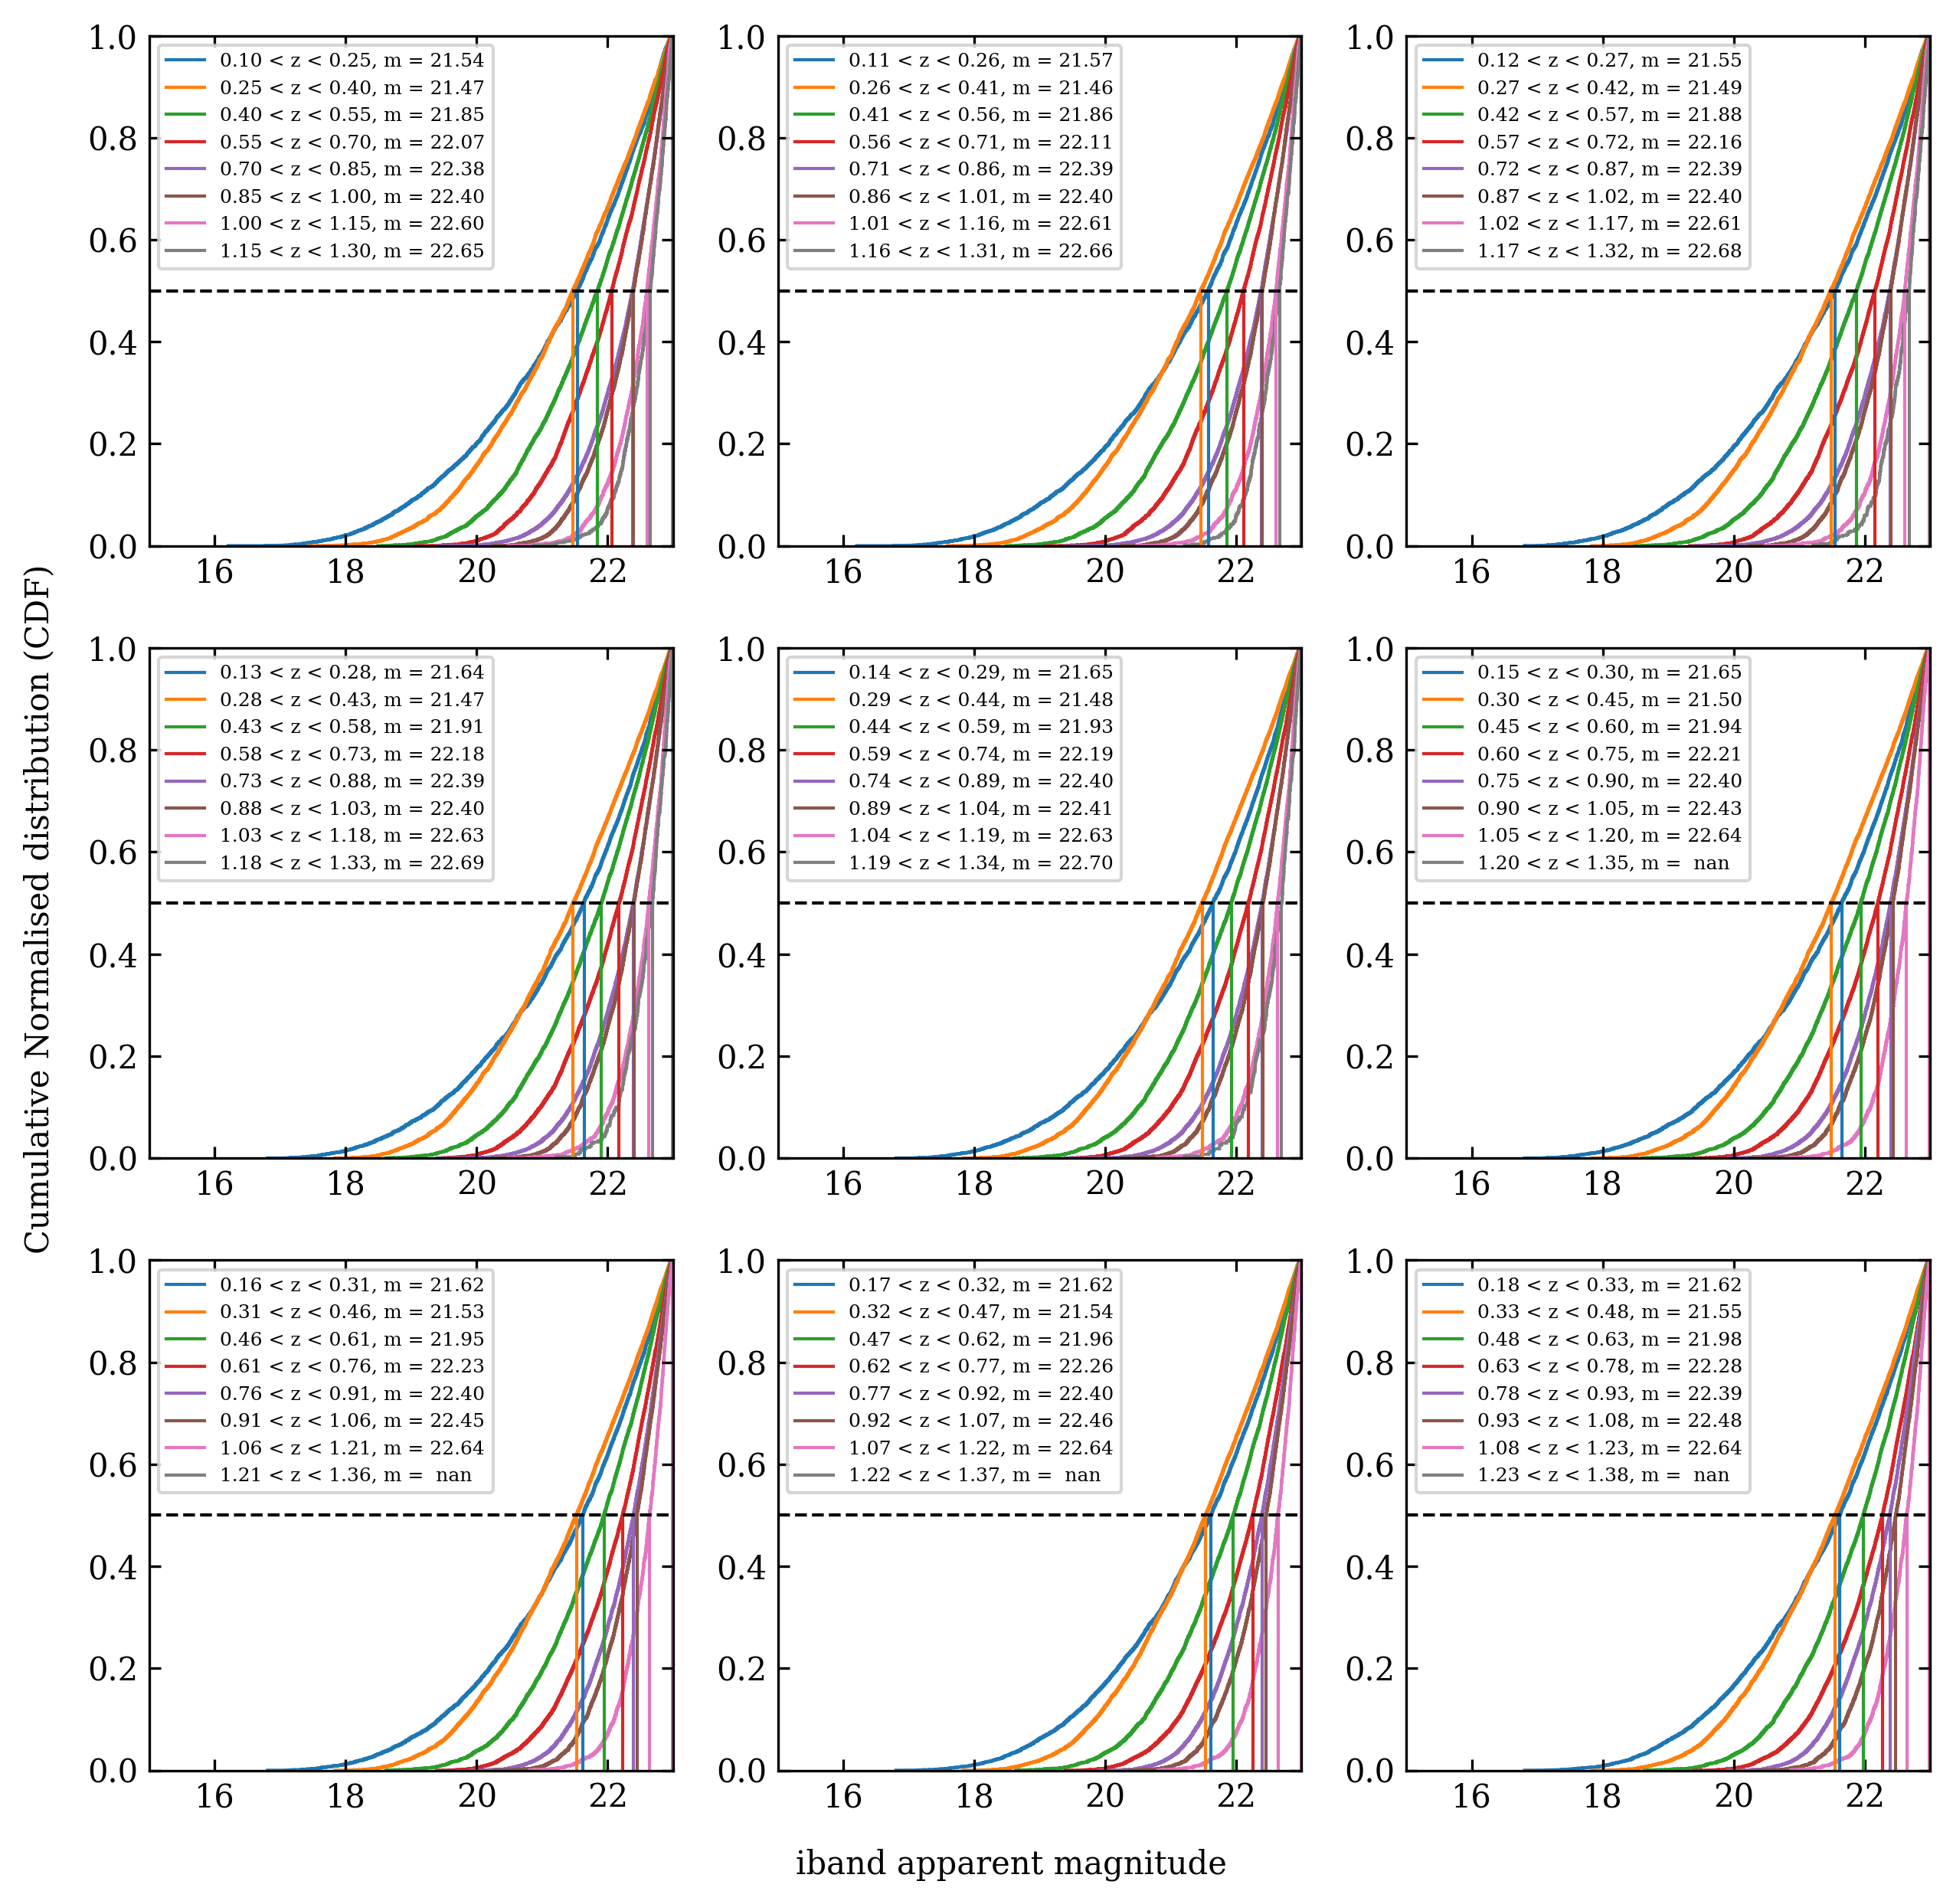

In [12]:
fig = plt.figure(figsize=(10,10),dpi=300)

lims_ = np.arange(0,0.09,0.01)
# print(lims_.size)
for i in range(lims_.size):
    ax = plt.subplot(331+i)
    bins = []
    bin_range = [0.1+lims_[i],1.2+lims_[i]]
#     print(bin_range)
    bin_increment = 0.15
    temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
    for ind,i in enumerate(temp_bins[:-1]):
        bins.append([temp_bins[ind],temp_bins[ind+1]])

    for ind,z_bin in enumerate(bins):

        truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)

        iband_mags = data_sample.loc[truth_table,'i_auto']
        N_objects = iband_mags.size
        median = np.median(iband_mags)
        hist = plt.hist(iband_mags,1000,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
        plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                    label='{:.02f} < z < {:.02f}, m = {:4.2f}'.format(z_bin[0],z_bin[1],median))
        plt.ylim((0,1))
        
        box = ax.get_position()
        #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='upper left', fontsize=6)
    
    
    plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
    plt.xlim((15,23))
# plt.xlabel('iband apparent magnitude')
# plt.ylabel('Cumulative Normalised distribution (CDF)')

# plt.legend()
fig.text(0.5, 0.08, 'iband apparent magnitude', ha='center')
fig.text(0.07, 0.5, 'Cumulative Normalised distribution (CDF)', va='center', rotation='vertical')
plt.show()
    

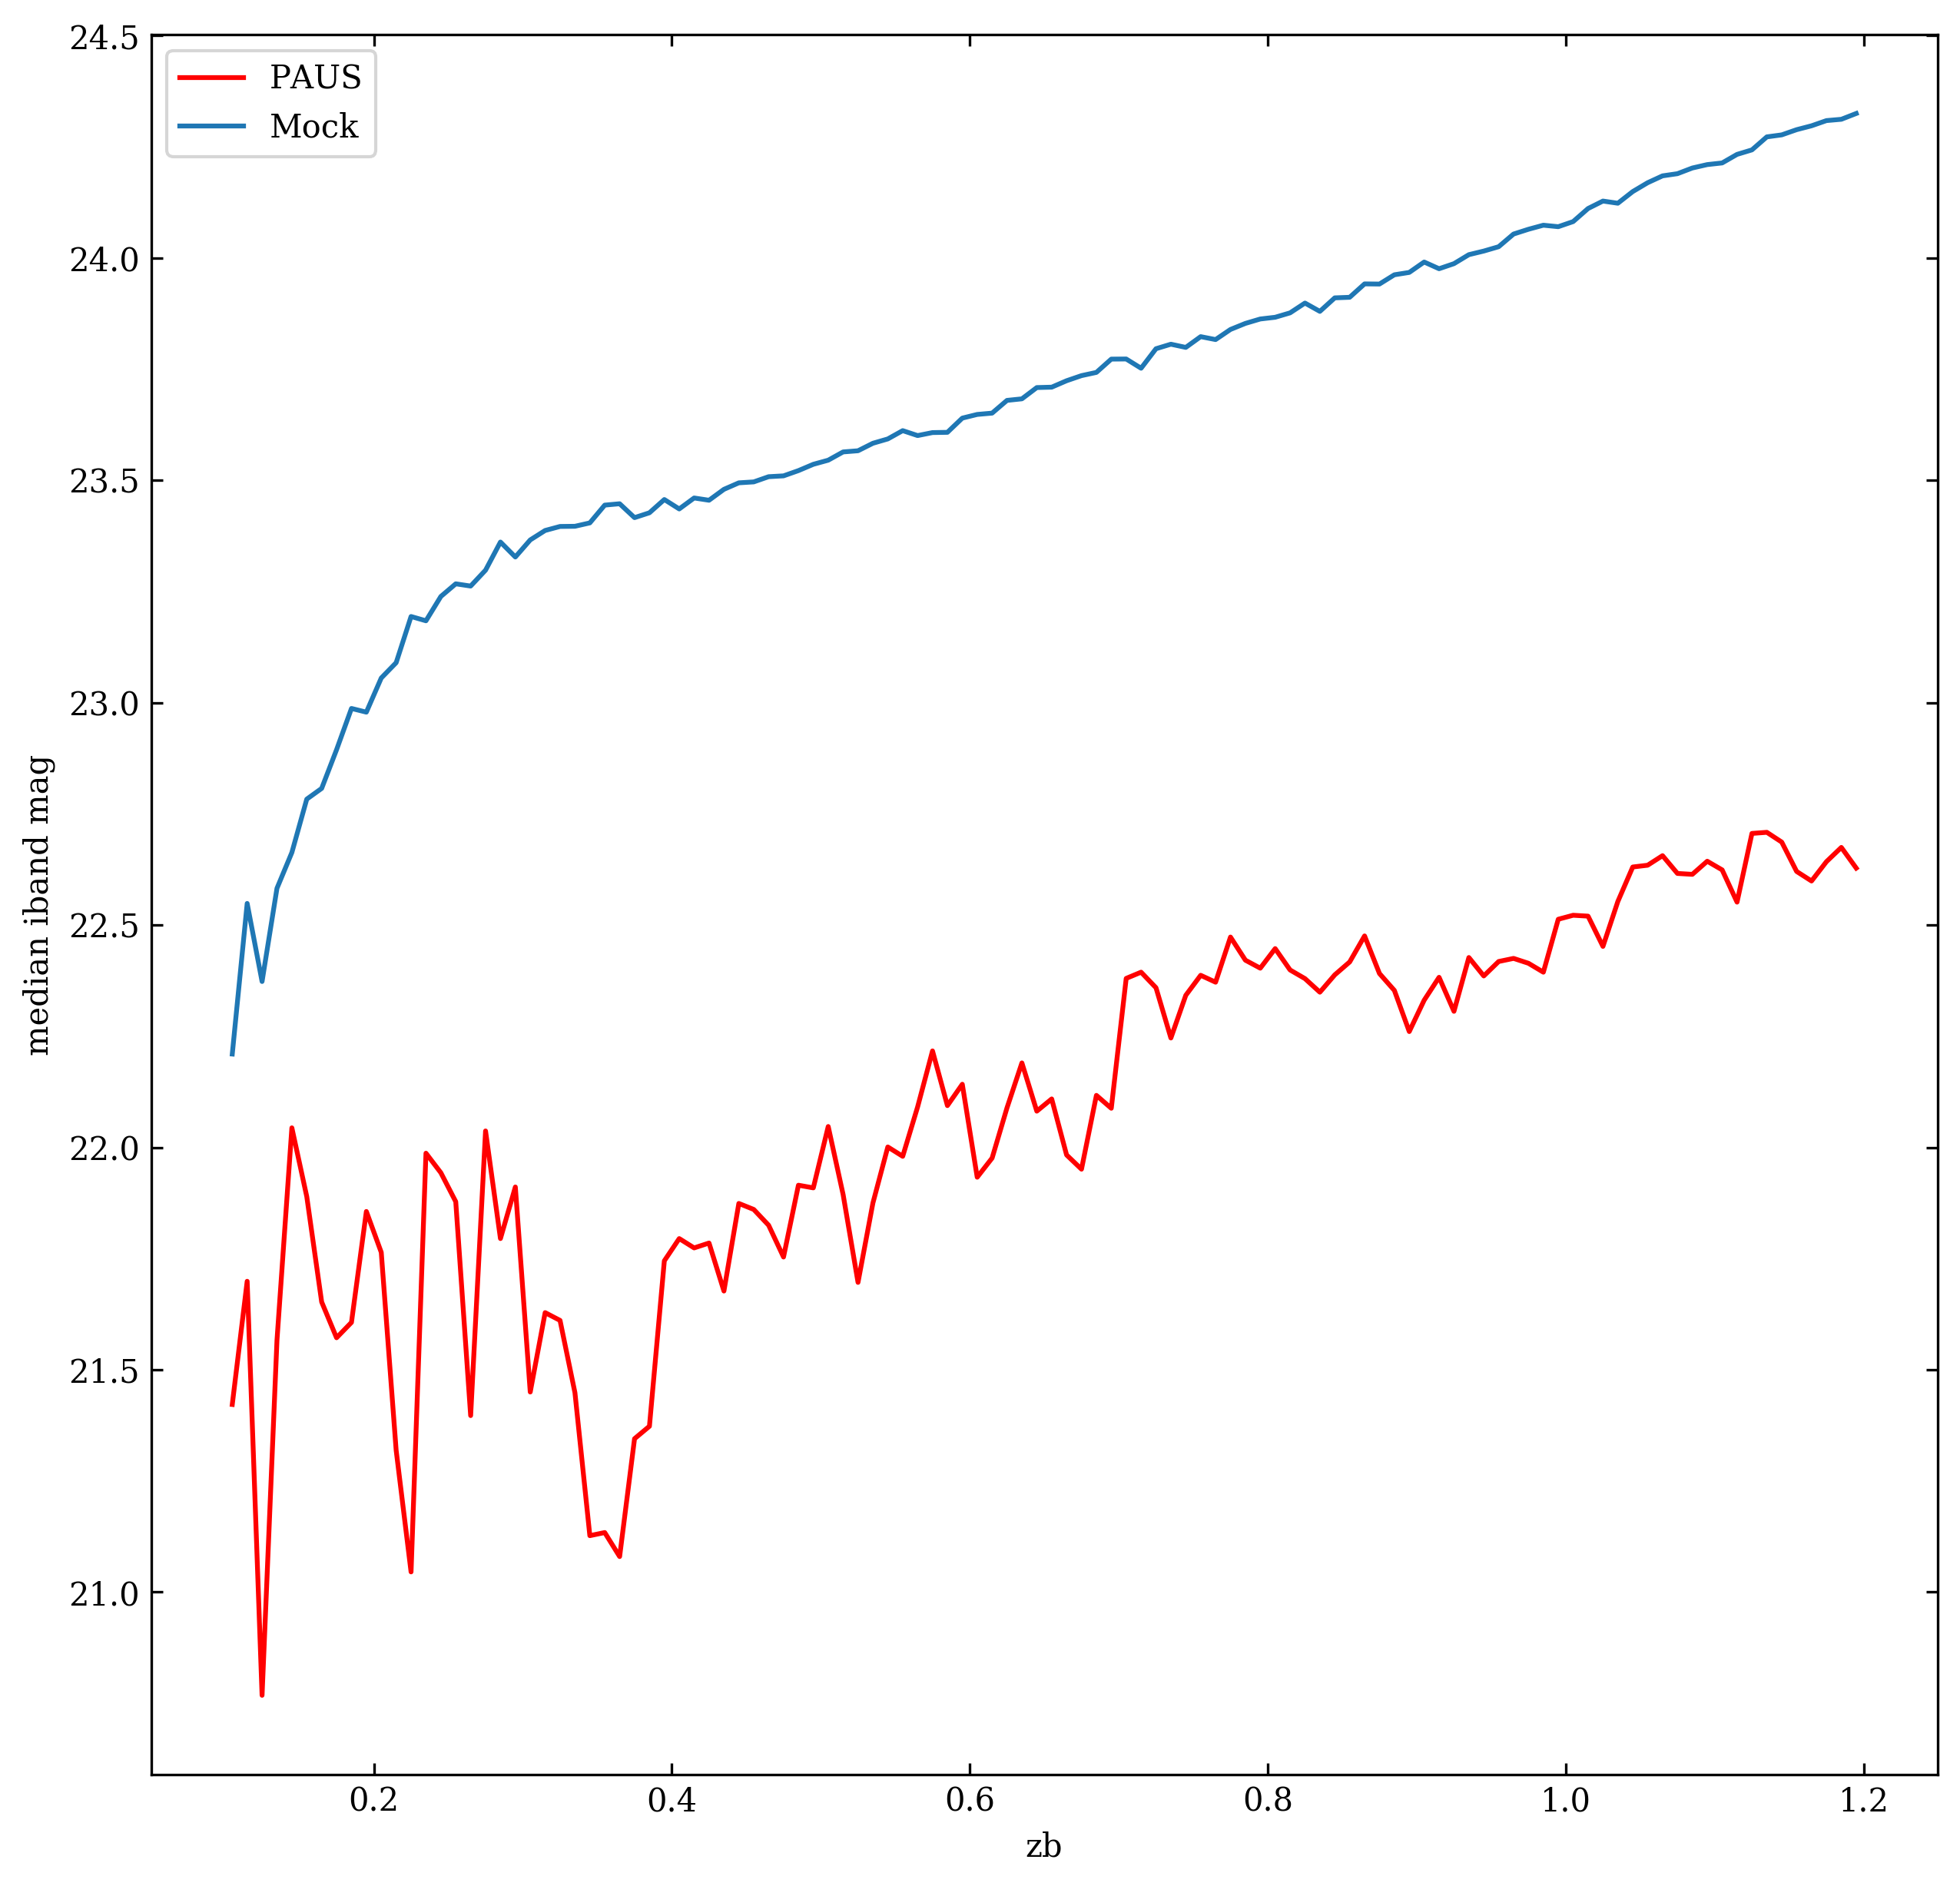

In [13]:
fig = plt.figure(figsize=(10,10),dpi=300)

# ax = plt.subplot(331+i)
bins = []
bin_range = [0.1,1.2]
#     print(bin_range)
bin_increment = 0.01
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

LC_zs = np.array(LC_DATA_CORE['Data/z_cos'])
LC_imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])

    
median_imags_PA = []
median_imags_LC = []

mid_zbins = []

for ind,z_bin in enumerate(bins):

    truth_table1 = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    truth_table2 = (LC_zs >= z_bin[0]) & (LC_zs <= z_bin[1])

    median_imags_PA.append(np.median(data_sample.loc[truth_table1,'i_auto']))   
    median_imags_LC.append(np.median(LC_imags[truth_table2]))
    
    mid_zbins.append((z_bin[0]+z_bin[1])/2)
    
plt.plot(mid_zbins,median_imags_PA,'r-',label='PAUS')
plt.plot(mid_zbins,median_imags_LC,label='Mock')
plt.legend()
plt.xlabel('zb')
plt.ylabel('median iband mag')
plt.show()


In [14]:
LC_DATA_PHOTOM.visit(lambda x: print(x))

Data
Data/GalaxyID
Data/app10o_tot
Data/app10o_tot_ext
Data/app11o_tot
Data/app11o_tot_ext
Data/app12o_tot
Data/app12o_tot_ext
Data/app13o_tot
Data/app13o_tot_ext
Data/app14o_tot
Data/app14o_tot_ext
Data/app15o_tot
Data/app15o_tot_ext
Data/app16o_tot
Data/app16o_tot_ext
Data/app17o_tot
Data/app17o_tot_ext
Data/app18o_tot
Data/app18o_tot_ext
Data/app19o_tot
Data/app19o_tot_ext
Data/app20o_tot
Data/app20o_tot_ext
Data/app21o_tot
Data/app21o_tot_ext
Data/app22o_tot
Data/app22o_tot_ext
Data/app23o_tot
Data/app23o_tot_ext
Data/app24o_tot
Data/app24o_tot_ext
Data/app25o_tot
Data/app25o_tot_ext
Data/app26o_tot
Data/app26o_tot_ext
Data/app27o_tot
Data/app27o_tot_ext
Data/app28o_tot
Data/app28o_tot_ext
Data/app29o_tot
Data/app29o_tot_ext
Data/app30o_tot
Data/app30o_tot_ext
Data/app31o_tot
Data/app31o_tot_ext
Data/app32o_tot
Data/app32o_tot_ext
Data/app33o_tot
Data/app33o_tot_ext
Data/app34o_tot
Data/app34o_tot_ext
Data/app35o_tot
Data/app35o_tot_ext
Data/app36o_tot
Data/app36o_tot_ext
Data/app3

# ML

In [15]:
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

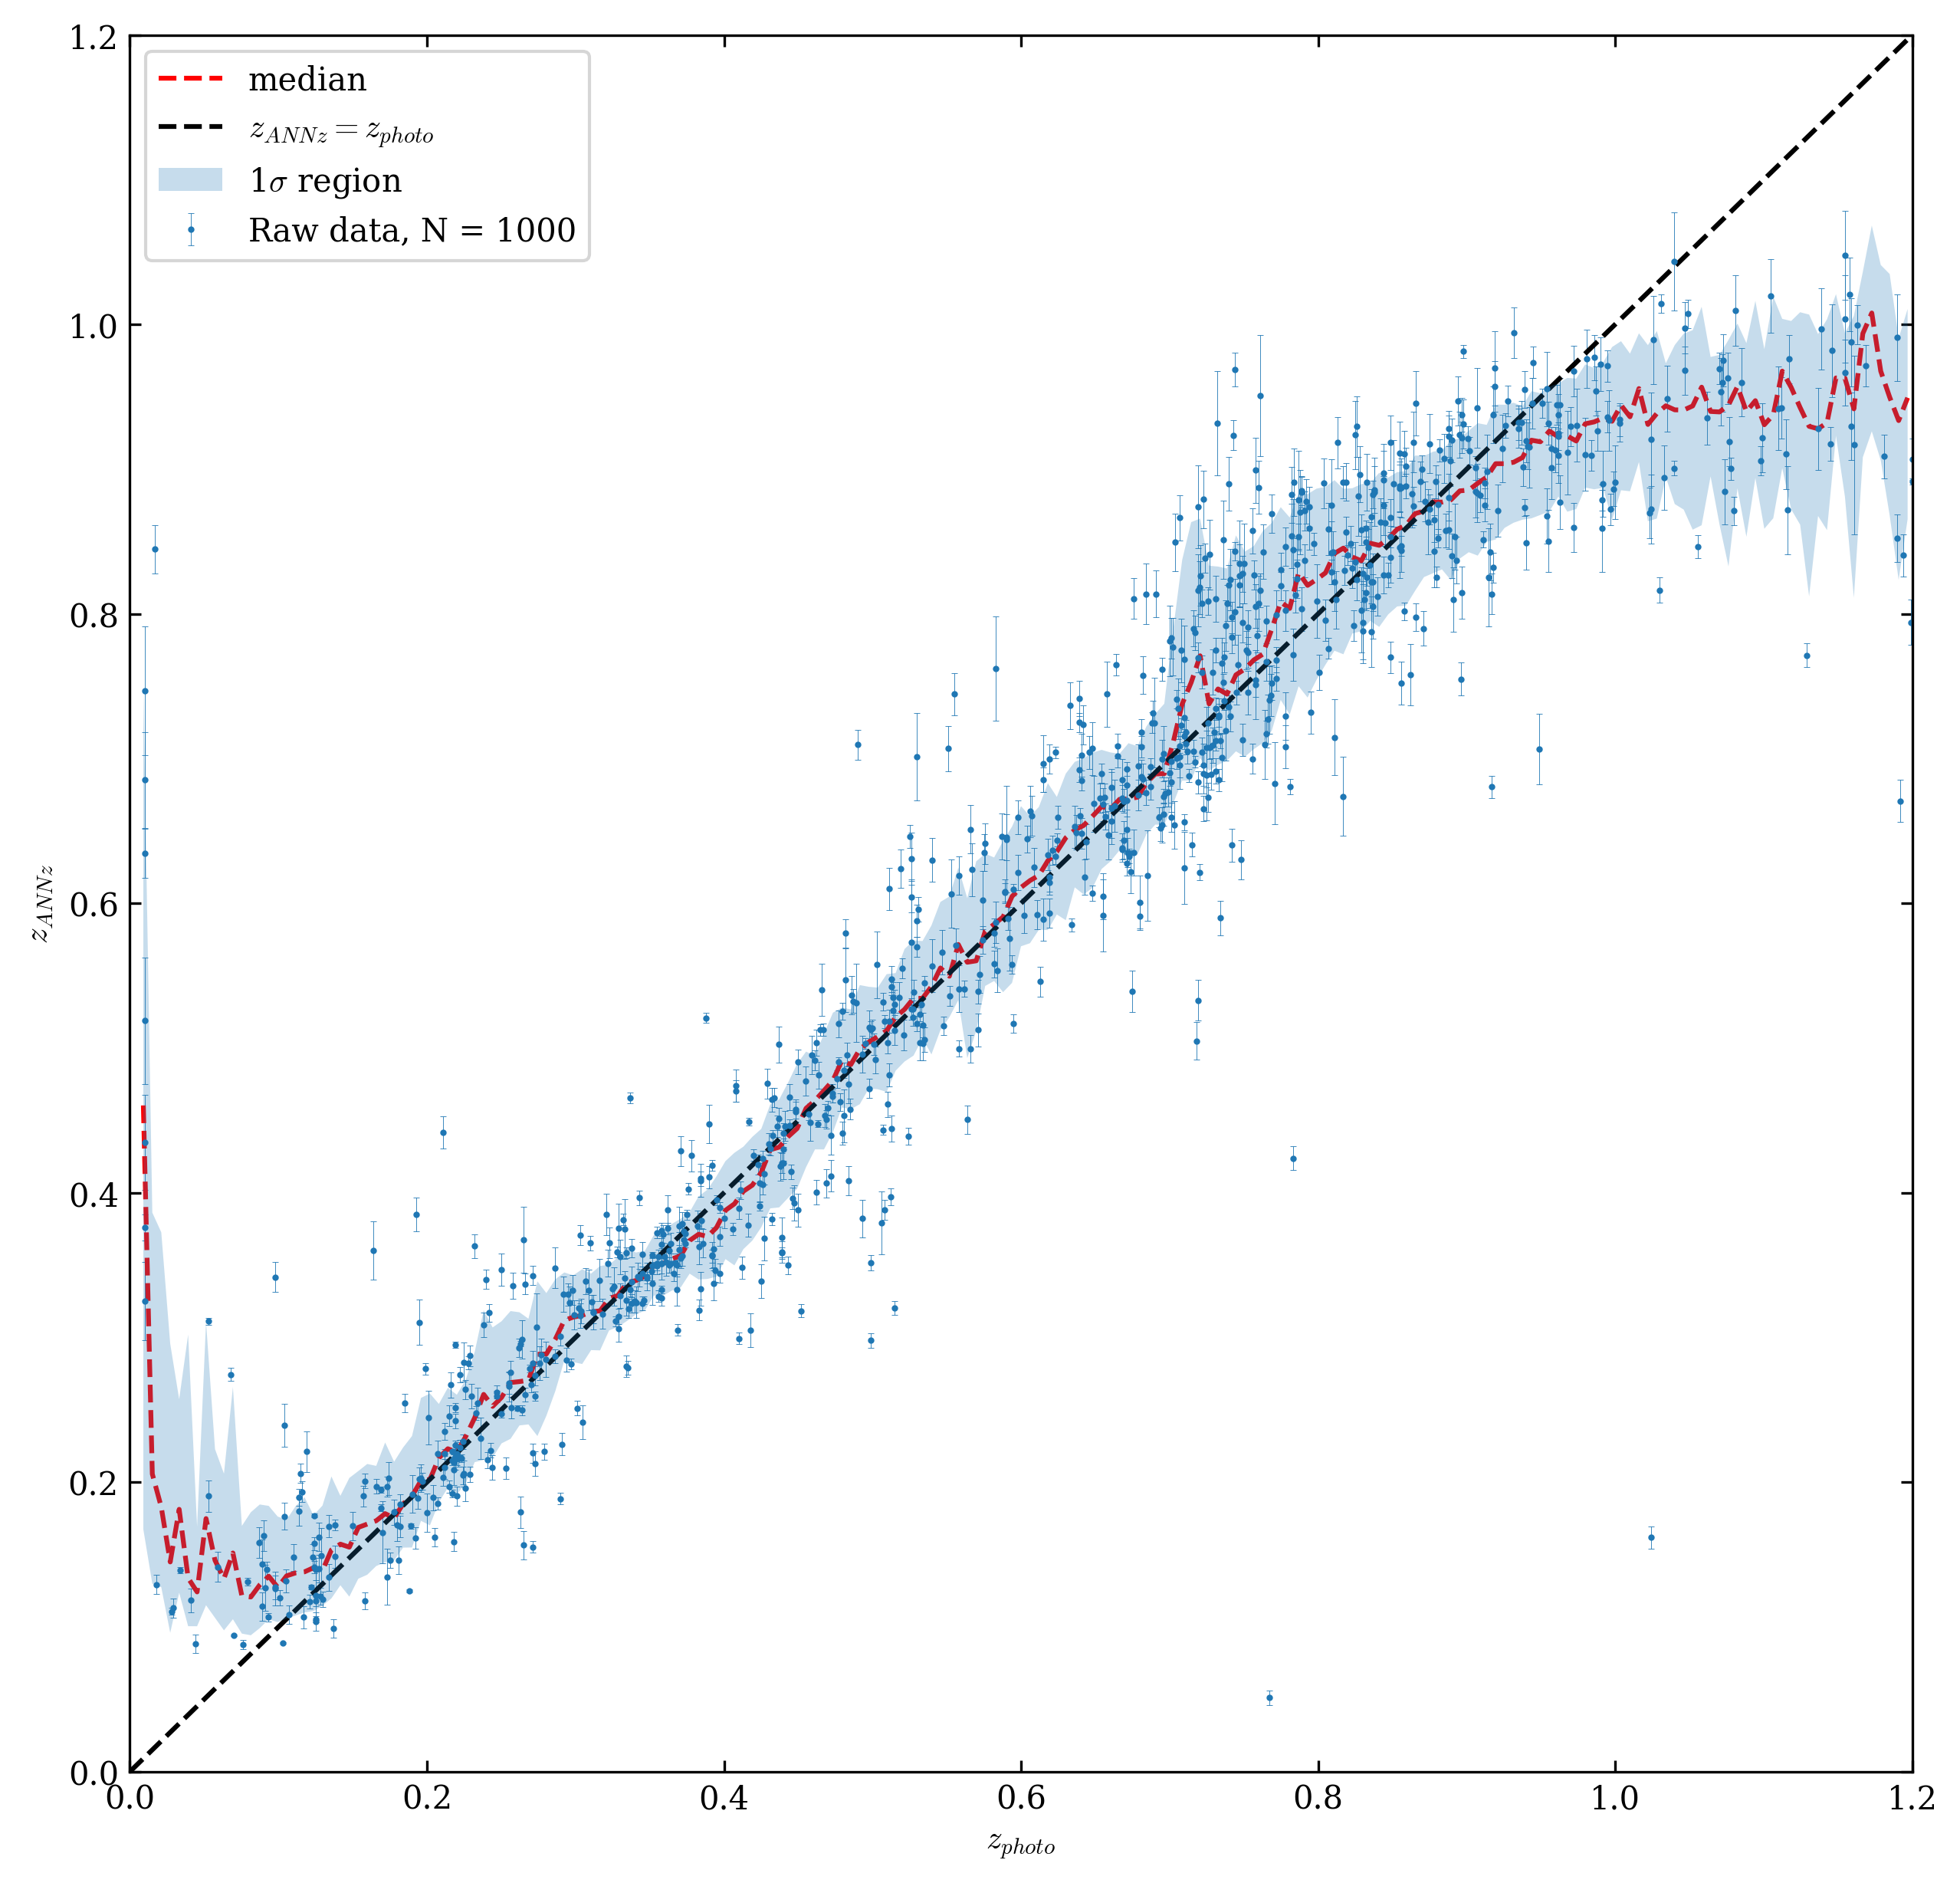

In [16]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced2/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
ML_DATA
# print(ML_DATA.shape)
N_points = 1000
indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)


bins = np.linspace(0,1.2,200)
meds = scipy.stats.binned_statistic(ML_DATA['F:Z'],ML_DATA['F:ANNZ_best'],'median',bins=bins)[0]
lbs = scipy.stats.binned_statistic(ML_DATA['F:Z'],ML_DATA['F:ANNZ_best'],lb68,bins)[0]
ubs = scipy.stats.binned_statistic(ML_DATA['F:Z'],ML_DATA['F:ANNZ_best'],ub68,bins)[0]

fig = plt.figure(figsize=(10,10),dpi=300)
plt.errorbar(ML_DATA.loc[indices,'F:Z'],ML_DATA.loc[indices,'F:ANNZ_best'],yerr=ML_DATA.loc[indices,'F:ANNZ_best_err']\
             ,fmt='o',ms=1,linewidth=0.2,capsize=1,capthick=0.2,label='Raw data, N = {}'.format(N_points))
plt.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='median')
plt.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$')
plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=10,label=r'1$\sigma$ region')
plt.xlabel(r'$z_{photo}$')
plt.ylabel(r'$z_{ANNz}$')
plt.legend()
plt.xlim(0,1.2)
plt.ylim(0,1.2)

plt.show()